<h1 style="text-align: center;">Singular Value Decomposition in Image Compression</h1>
<h3 style="text-align: center;">Aritra Mukhopadhyay<br>Roll: 2011030</h3>
<h5 style="text-align: center;">P346 DIY Project</h5>

# Introduction

&emsp; We work a lot with images in our daily life. We use them for various purposes like storing memories, sharing them with our friends and family, etc. But, the problem is that images are very large in size. For example, a 1080p uncompressed colour image is around 6 MB* in size. So, if we want to store a lot of images, we need a lot of storage space. Moreover, larger images will be read slower from the disk and any operations done on it will be slower too. Can we avoid this? Is there a way to store the same 6 MB image in a smaller space? In this project, we will discuss how we can compress images and store them in a smaller space using the singular value decomposition (SVD) method.

&emsp; The SVD is a factorization of a real or complex matrices. It is widely used in numerical linear algebra, and is one of the most important matrix factorizations. The SVD is used to solve a wide range of problems in science, engineering, and mathematics. It is also used in **image compression**, recommender systems, and in numerical methods for solving partial differential equations. We will learn how to use SVD to compress image data with no or very small loss in quality.

*A 1080p image is 1920x1080 pixels. Each pixel has 3 values (RGB). Considering this as an 8 bit (= 1 byte) image: $$(1920\times1080\times3) Bytes = 6220800 Bytes \approx 5.93 MB $$

# Singular Value Decomposition (SVD)

&emsp; Singular Value Decomposition (SVD) is a method of factorising a matrix $A$ (say) into three of its components.

$$A_{n\times n} = U_{n\times n}\cdot S_{n\times n}\cdot V_{n\times n}$$

&emsp; $S$ is a diagonal matrix with all non-diagonal elements zero. The diagonal elements of $S$ are called the **singular values** of $A$. The columns of $U$ and $V$ are called the **left and right singular vectors** of $A$ respectively.

&emsp; Here, $U$ and $V$ are unitary matrices and $S$ is a diagonal matrix. The diagonal elements of $S$ are called the singular values of $A$. The columns of $U$ are called the left singular vectors of $A$ and the columns of $V$ are called the right singular vectors of $A$. The singular values of $A$ are the square roots of the eigenvalues of $A^*A$ and $A A^*$.

&emsp; *Note:* $S$ is a diagonal matrix with all non-diagonal elements zero. So, we we can write $S$ as a vector of singular values $\sigma_i$.


<!-- $$
A = \left(\begin{array}{cc} 
0.8944272 & 0.4472136\\
-0.4472136 & -0.8944272
\end{array}\right)

\left(\begin{array}{cc} 
10 & 0\\ 
0 & 5
\end{array}\right)
$$ -->

## Building up the Intuition
&emsp; Let us start by having an intuitive idea of what we are trying to achieve. Let us consider this matrix $A$:

$$
A_{4\times4} = 
\left(
    \begin{array}{cc}
        1 & 2 & 3 & 4\\
        2 & 4 & 6 & 8\\
        5 & 10 & 15 & 20\\
        10 & 20 & 30 & 40\\
    \end{array}
\right)
$$

&emsp; This is a $4\times4$ matrix. So apparently we need $(4\times4 = )$ 16 memory units to store the entire matrix in its true form. On the other hand we can clearly see that this matrix can be writen in a slightly different way:

$$
\left(
    \begin{array}{cc}
        1 & 2 & 3 & 4\\
        2 & 4 & 6 & 8\\
        5 & 10 & 15 & 20\\
        10 & 20 & 30 & 40\\
    \end{array}
\right)=
\left(
    \begin{array}{cc}
        1\\
        2\\
        5\\
        10\\
    \end{array}
\right)\times
\left(
    \begin{array}{cc}
        1 & 2 & 3 & 4\\
    \end{array}
\right)
$$

&emsp; We can clearly see that this $4\times4$ matrix can be stored using only $8$ numbers. So, we have reduced the memory requirement by a factor of $2$. This was just a $4\times4$ matrix, imagine if we can express a $1000\times1000$ matrix (which was supposed to take $10^6$ memory units) as a product of a row and a column matrix, we can store it using only $2000$ units of memory ($500$ times reduction in size). This is what we are trying to achieve in this project.

&emsp; Now obviously we won't always be fortunate enough to get a matrix which can be expressed as a product of a row and a column matrix, but it can be proved that for any matrix $A_{n\times n}$ we can always express it like this:
$$A_{n\times n} = \sum_{i=1}^n (\sigma_iC_i\times R_i)$$

&emsp; Here, $\sigma_i$ is a real number (where $\sigma_a>\sigma_b$ if $a<b$). $C_i$ and $R_i$ are column and row matrices respectively of sizes $n$.

&emsp; Now, according to the theory, we need n terms to express a $n\times n$ matrix. But, in practical scenario, we can get away with much less terms. This is because, as the values of $\sigma_i$ decrease, the contribution of the corresponding term to the matrix $A$ also decreases.

<!-- ## Choosing the number of terms
&emsp; Let us choose a **compression factor** $\alpha$ (say, where $0<\alpha<1$) before compression. Then we can keep on adding the $i^{th}$ term untill 

$$\sum_{j=1}^i\sigma_j\geq\alpha\sum_{j=1}^n\sigma_j$$

**Note:** We know that $\sigma_a>\sigma_b$ if $a<b$ so this scheme will always choose the terms with the highest singular values. We also know that all the $\sigma s$ are non-negative. -->

## Now let's see how it works:
### We will first try our hands upon a grayscale image

Grayscale images are images in which every pixel has a single brightness value. So it is easier to work with.

In [ ]:
# Importing necessary libraries
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from library.DIY import *
from math import isnan
from tqdm import tqdm

In [ ]:
# Loading the image
pic = "lion"
A = imread(f'static/{pic}/{pic}.jpg')# @np.array([0.2989, 0.5870, 0.1140])*255
A = A.astype("int")
print(f"Raw Image Size = {round(A.shape[0]*A.shape[1]/1024**2, 2)} MB")
show_image(A, "Original Grayscale Square Image")

### Using numpy.linalg.svd() function:

&emsp; We can use the `numpy.linalg.svd()` function to compute the SVD of a matrix. The function returns the singular values in descending order. So, we can use the same method as above to choose the number of terms. The function returns the matrix $S$ not in the form of a diagonal matrix but as a vector of singular values. So, we will have to convert it into a diagonal matrix before we can use it to reconstruct the matrix $A$.

&emsp; **Why are we using the SVD function from numpy and not writing our own SVD function?** This is because the SVD function from numpy is written in C and is highly optimized. So, it is much faster than our own implementation. Moreover finding SVD of a matrix involves finding eigenvalues and eigenvectors of the matrix. We know that the algorithms studied in this class becomes inefficient if we are working with a large matrix. The later values have a lot of error in them. So, writing the SVD function is itself a huge problem to be solved. On the other hand, finding SVD of a matrix is a very well studied problem in literature and there are many efficient algorithms to find it. So, we can use the SVD function from numpy without reinveting the wheel.

In [ ]:
# Finding Singular Value Decomposition of "A" using NumPy
U, S, V = np.linalg.svd(A)
S = np.diag(S)

In [ ]:
terms = 50
A_ = U[:, :terms]@S[:terms, :terms]@V[:terms, :]
A_ = A_.astype("int")

size, comp = comp_percent(A.shape, terms)
rms_error = get_rms_error(A, A_)
print(f"rms_error = {round(rms_error, 1 if rms_error>10 else 2)} = {round(rms_error/2.55, 2)}%")

show_image(
    A_,
    f"{terms = }, size = {int(size)} KB ({round(comp, 1 if comp>1 else 2)}%)"
)

In [ ]:
# ts = range(2, 503, 4)
# # ts = [1, 5, 10, 20, 50, 100, 200, 500]

# comps, errors, indices = [], [], []
# for terms in tqdm(ts):
#     A_, comp, rms_error, text = get_image(terms, U, S, V, A)
#     # plt.imsave(f"static/{pic}/{terms}.jpg", A_, cmap='gray')
#     if not isnan(rms_error):
#         comps.append(comp)
#         errors.append(rms_error)
#         indices.append(terms)

In [ ]:
# # plt.axis("tight")
# plt.axes(xlabel = "Number of terms", ylabel = "Error", )
# plt.plot(indices, errors)

In [ ]:
pic = "crab"
img = ColourImageSVD(f"static/{pic}/{pic}.jpg")

In [ ]:
a = img.reduce(terms = 15)
plt.imshow(a)

In [ ]:
plt.imsave(f"static/{pic}/15_2.jpg", a)

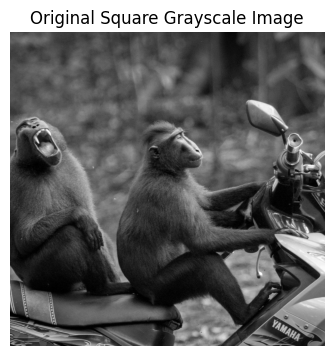

In [1]:
from library.DIY import GrayscaleImageSVD
pic = "monkey"
img = GrayscaleImageSVD(f"static/{pic}.jpg")
img.display("Original Square Grayscale Image")

In [ ]:
reduced = img.reduce(terms = 50)
